In [6]:
from NASBench import NASBench1Shot1
import sys, os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from source.nasbench.nasbench import api as nasbenchAPI
import numpy as np
api = NASBench1Shot1.NASBench1Shot1(use_colab=False)

TypeError: __init__() missing 1 required positional argument: 'search_space'

## Layer construction

### Output layer
**Conv1x1** $\rightarrow$ **Batch Normalization** $\rightarrow$ **ReLU**

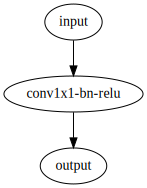

In [4]:
cell.visualize()

In [5]:
def CellToUppertriangular(cell) -> list:
    upper_triangle = []
    matrixSize = len(cell)
    for i in range(0, matrixSize, 1):
        for j in range(i, matrixSize, 1):
            upper_triangle.append(cell[i][j])
    return upper_triangle   

In [6]:
cell.__dict__['ops']

['input', 'conv1x1-bn-relu', 'output']

In [27]:
def repair_connection(ind, ops):
    cell = nasbenchAPI.ModelSpec(matrix=np.array(ind), ops=ops)
    
    # if input does not link to any operation 
    # then input -> output
    if cell.__dict__['matrix'] is None: 
        return [[0, 0, 0, 0, 0, 0, 1,],
                [0, 0, 0, 0, 0, 0, 0,],
                [0, 0, 0, 0, 0, 0, 0,],
                [0, 0, 0, 0, 0, 0, 0,],
                [0, 0, 0, 0, 0, 0, 0,],
                [0, 0, 0, 0, 0, 0, 0,],
                [0, 0, 0, 0, 0, 0, 0,]]
        
    operation = cell.__dict__['ops']
    used_operation = {
        'conv5x5' : False
    }
    use_5x5 = False 
    matrix = cell.__dict__['original_matrix'] if cell.__dict__['matrix'] is not None else ind
    
    if cell.__dict__['ops'] is not None:
        for op in ops:
            used_operation[op] = True if ops in operation else False
    
    if matrix[0][4] == 1 and matrix[0][5] == 1:
        used_operation['conv5x5'] = True
   
    if used_operation['conv1x1-bn-relu']:
        matrix[1][len(matrix) - 1] = 1
    
    if used_operation['conv5x5']:
        matrix[3][4] = 1 # link to the other 3x3 connection
        matrix[4][len(matrix) - 1] = 1 # link to output
    
    if used_operation['maxpool3x3']:
        matrix[5][len(matrix) - 1] = 1
    
    if matrix[0][2] == 1:
        matrix[2][len(matrix) - 1] = 1 # use conv3x3
    
    if (matrix[0][3] == 1 and matrix[0][4] == 0): # use conv3x3 only
        matrix[3][len(matrix) - 1] = 1
    if (matrix[0][3] == 0 and matrix[0][4] == 1): # use conv3x3 only
        matrix[4][len(matrix) - 1] = 1       
        
    return matrix

In [11]:
ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT]
# repair_connection(ind=[[0, 0, 0, 0, 0, 0, 1,],
#                     [0, 0, 0, 0, 0, 0, 0,],
#                     [0, 0, 0, 0, 0, 0, 0,],
#                     [0, 0, 0, 0, 0, 0, 0,],
#                     [0, 0, 0, 0, 0, 0, 0,],
#                     [0, 0, 0, 0, 0, 0, 0,],
#                     [0, 0, 0, 0, 0, 0, 0,]], ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])
cell = nasbenchAPI.ModelSpec(matrix=np.array([[0, 1, 0, 1,],
                                            [0, 0, 1, 0,],
                                            [0, 0, 0, 1,],
                                            [0, 0, 0, 0,]]), ops=[INPUT, 'conv3x3-bn-relu', 'conv3x3-bn-relu', OUTPUT])
print(api.api.query(cell, epochs=4))
# cell.visualize()

{'module_adjacency': array([[0, 1, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0]], dtype=int8), 'module_operations': ['input', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output'], 'trainable_parameters': 20346506, 'training_time': 96.76300048828125, 'train_accuracy': 0.3701923191547394, 'validation_accuracy': 0.37379807233810425, 'test_accuracy': 0.3742988705635071}


In [29]:
test_ind = [[0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1],
            [0, 0, 0, 0, 0, 0, 0]]
api.is_valid(test_ind)

True